In [1]:
import numpy as np
import pandas as pd
import datetime

import pytest

from Outcomes import outcomes
from SEIR.utils import config



import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import glob, os, sys
from pathlib import Path
#import seaborn as sns
import pyarrow.parquet as pq
import click
import pyarrow as pa

import os

os.chdir('COVIDScenarioPipeline/Outcomes/test')


geoid = ['15005', '15007', '15009', '15001', '15003']
diffI = np.arange(5)*2
date_data = datetime.date(2020,4,15)
subclasses = ['_A', '_B']

### Creating a test file from the inference test:

In [2]:
seir = pq.read_table('model_output/seir/000000001.1.seir.parquet').to_pandas()
seir[[i for i in seir.columns if '15' in i]] = 0
seir.loc[(seir['time'] == '2020-04-15') & (seir['comp'] == 'diffI'), [i for i in seir.columns if '15' in i]] = np.arange(5)*2
seir[(seir['time'] == '2020-04-15') & (seir['comp'] == 'diffI')][[i for i in seir.columns if '15' in i]]

seirT = pa.Table.from_pandas(seir, preserve_index=False)
#pa.parquet.write_table(seirT, 'model_output/seir/000000001.1.seir.parquet')
#pa.parquet.write_table(seirT, 'model_output/seir/000000001.2.seir.parquet')

# Test classical load from config

In [3]:
config.set_file('config.yml')

run_id = 1
index = 1
deathrate = 'high_death_rate'
prefix = ''
stoch_traj_flag = False
outcomes.run_delayframe_outcomes(config, run_id, prefix, int(index), run_id, prefix, int(index), # output
                        deathrate, nsim=1, n_jobs=1, stoch_traj_flag = stoch_traj_flag)

NOT LOADED VALUES !!!
[0.1 0.1 0.1 0.1 0.1]
NOT LOADED VALUES !!!
[0.01 0.01 0.01 0.01 0.01]
NOT LOADED VALUES !!!
[0.4 0.4 0.4 0.4 0.4]

>> 1 outcomes simulations completed in 0.0 seconds



1

In [4]:
hosp = pq.read_table('model_output/hosp/000000001.1.hosp.parquet').to_pandas()
hosp.set_index('time', drop=True, inplace = True)

for i, place  in enumerate(geoid):
    for dt in hosp.index:
        if dt == date_data:
            assert(hosp[hosp['geoid']==place]['incidI'][dt] == diffI[i])
            assert(hosp[hosp['geoid']==place]['incidH'][dt+datetime.timedelta(7)] == diffI[i]*.1)
            assert(hosp[hosp['geoid']==place]['incidD'][dt+datetime.timedelta(2) ] == diffI[i]*.01)
            assert(hosp[hosp['geoid']==place]['incidICU'][dt+datetime.timedelta(7)] == diffI[i]*.1*.4)
            for j in range(7):
                assert(hosp[hosp['geoid']==place]['hosp_curr'][dt+datetime.timedelta(7+j)] == diffI[i]*.1)
            assert(hosp[hosp['geoid']==place]['hosp_curr'][dt+datetime.timedelta(7+8)] == 0)

        elif dt < date_data:
            assert(hosp[hosp['geoid']==place]['incidH'][dt+datetime.timedelta(7)] == 0)
            assert(hosp[hosp['geoid']==place]['incidI'][dt] == 0)
            assert(hosp[hosp['geoid']==place]['incidD'][dt+datetime.timedelta(2)] == 0)
            assert(hosp[hosp['geoid']==place]['incidICU'][dt+datetime.timedelta(7)] == 0)
            assert(hosp[hosp['geoid']==place]['hosp_curr'][dt+datetime.timedelta(7)] == 0)
        elif dt > (date_data + datetime.timedelta(7)):
            assert(hosp[hosp['geoid']==place]['incidH'][dt] == 0)
            assert(hosp[hosp['geoid']==place]['incidI'][dt-datetime.timedelta(7)] == 0)
            assert(hosp[hosp['geoid']==place]['incidD'][dt-datetime.timedelta(4)] == 0)
            assert(hosp[hosp['geoid']==place]['incidICU'][dt] == 0)
hpar = pq.read_table('model_output/hpar/000000001.1.hpar.parquet').to_pandas()

for i, place  in enumerate(geoid):
    assert(float(hpar[(hpar['geoid']== place) & (hpar['outcome']== 'incidH') & (hpar['quantity'] == 'probability')]['value']) == 0.1)
    assert(float(hpar[(hpar['geoid']== place) & (hpar['outcome']== 'incidH') & (hpar['quantity'] == 'delay')]['value']) == 7)
    assert(float(hpar[(hpar['geoid']== place) & (hpar['outcome']== 'incidH') & (hpar['quantity'] == 'duration')]['value']) == 7)
    assert(float(hpar[(hpar['geoid']== place) & (hpar['outcome']== 'incidD') & (hpar['quantity'] == 'probability')]['value']) == 0.01)
    assert(float(hpar[(hpar['geoid']== place) & (hpar['outcome']== 'incidD') & (hpar['quantity'] == 'delay')]['value']) == 2)
    assert(float(hpar[(hpar['geoid']== place) & (hpar['outcome']== 'incidICU') & (hpar['quantity'] == 'probability')]['value']) == 0.4)
    assert(float(hpar[(hpar['geoid']== place) & (hpar['outcome']== 'incidICU') & (hpar['quantity'] == 'delay')]['value']) == 0)

### Built test relative prob

In [5]:
rel_prob = pq.read_table('model_output/hpar/000000001.1.hpar.parquet').to_pandas()
rel_prob = rel_prob[rel_prob['quantity'] == 'probability']
rel_prob = rel_prob[rel_prob['quantity'] == 'probability']
rel_prob['quantity'] = 'relative_probability'
for i, place  in enumerate(geoid):
    rel_prob.loc[(rel_prob['geoid'] == place)&(rel_prob['outcome'] == 'incidH'),'value'] = rel_prob[rel_prob['geoid'] == place]['value'] * diffI[i]

    
    
# change order to test re-aranging node
rel_prob = rel_prob.sample(frac=1).reset_index(drop=True)
rel_probT = pa.Table.from_pandas(rel_prob, preserve_index=False)
#pa.parquet.write_table(rel_probT, 'test_rel.parquet')

In [6]:
rel_prob

,geoid,quantity,outcome,source,value
0,15007,relative_probability,incidD,incidI,0.01
1,15007,relative_probability,incidH,incidI,0.20
2,15003,relative_probability,incidICU,incidH,0.40
3,15007,relative_probability,incidICU,incidH,0.40
4,15005,relative_probability,incidH,incidI,0.00
5,15009,relative_probability,incidICU,incidH,0.40
6,15001,relative_probability,incidH,incidI,0.60
7,15009,relative_probability,incidH,incidI,0.40
8,15005,relative_probability,incidICU,incidH,0.40
9,15003,relative_probability,incidD,incidI,0.01


# Test the load relative parameters

In [7]:
config.clear()
config.read(user=False)
config.set_file('config_load.yml')

run_id = 1
index = 1
deathrate = 'high_death_rate'
prefix = ''
stoch_traj_flag = False
outcomes.run_delayframe_outcomes(config, run_id, prefix, int(index), run_id+1, prefix, int(index), # output
                        deathrate, nsim=1, n_jobs=1, stoch_traj_flag = stoch_traj_flag)

Loaded geoids in loaded relative probablity file: 5 Intersect with seir simulation:  5 keeped
Using 'param_from_file' for relative probability incidI -->  incidH
Using 'param_from_file' for relative probability incidI -->  incidD
Using 'param_from_file' for relative probability incidH -->  incidICU
NOT LOADED VALUES !!!
[0.   0.02 0.04 0.06 0.08]
NOT LOADED VALUES !!!
[0.0001 0.0001 0.0001 0.0001 0.0001]
NOT LOADED VALUES !!!
[0.16 0.16 0.16 0.16 0.16]

>> 1 outcomes simulations completed in 0.1 seconds



1

In [8]:
hpar_config = pq.read_table('model_output/hpar/000000001.1.hpar.parquet').to_pandas()
hpar_rel = pq.read_table('model_output/hpar/000000001.2.hpar.parquet').to_pandas()
for out in ['incidH', 'incidD', 'incidICU']:
    for i, place  in enumerate(geoid):
        a = hpar_rel[(hpar_rel['outcome'] == out) & (hpar_rel['geoid'] == place)]
        b = hpar_config[(hpar_rel['outcome'] == out) & (hpar_config['geoid'] == place)]
        assert(len(a)== len(b))
        for j in range(len(a)):
            if (b.iloc[j]['quantity'] in ['delay', 'duration']):
                assert(a.iloc[j]['value'] == b.iloc[j]['value'])
            else: #probabiliy
                if b.iloc[j]['outcome'] == 'incidD': 
                    assert(a.iloc[j]['value'] == b.iloc[j]['value']*0.01)
                elif b.iloc[j]['outcome'] == 'incidICU': 
                    assert(a.iloc[j]['value'] ==  b.iloc[j]['value']*0.4)
                elif b.iloc[j]['outcome'] == 'incidH': 
                    assert(a.iloc[j]['value'] == b.iloc[j]['value']*diffI[i]*0.1)

In [9]:
config.clear()
config.read(user=False)
config.set_file('config_load.yml')

run_id = 1
index = 1
deathrate = 'high_death_rate'
prefix = ''
stoch_traj_flag = False
outcomes.onerun_delayframe_outcomes_load_hpar(config, 2, prefix, int(index), # input
                                                      3, prefix, int(index), # output
                                                     deathrate, stoch_traj_flag)

Loaded geoids in loaded relative probablity file: 5 Intersect with seir simulation:  5 keeped
Using 'param_from_file' for relative probability incidI -->  incidH
Using 'param_from_file' for relative probability incidI -->  incidD
Using 'param_from_file' for relative probability incidH -->  incidICU
Using LOADED VALUES !!!
[0.   0.02 0.04 0.06 0.08] incidH incidI
    geoid     quantity   outcome  source   value
0   15005  probability    incidH  incidI  0.0000
1   15007  probability    incidH  incidI  0.0200
2   15009  probability    incidH  incidI  0.0400
3   15001  probability    incidH  incidI  0.0600
4   15003  probability    incidH  incidI  0.0800
5   15005        delay    incidH  incidI  7.0000
6   15007        delay    incidH  incidI  7.0000
7   15009        delay    incidH  incidI  7.0000
8   15001        delay    incidH  incidI  7.0000
9   15003        delay    incidH  incidI  7.0000
10  15005     duration    incidH  incidI  7.0000
11  15007     duration    incidH  incidI  7.000

1

In [10]:
hpar_read = pq.read_table('model_output/hpar/000000001.2.hpar.parquet').to_pandas()
hpar_wrote = pq.read_table('model_output/hpar/000000001.3.hpar.parquet').to_pandas()
assert((hpar_read == hpar_wrote).all().all())

# Test with subclasses

In [11]:
config.clear()
config.read(user=False)
config.set_file('config_subclasses.yml')

run_id = 1
index = 1
deathrate = 'high_death_rate'
prefix = ''
stoch_traj_flag = False
outcomes.run_delayframe_outcomes(config, run_id, prefix, int(index), 10, prefix, int(index), # output
                        deathrate, nsim=1, n_jobs=1, stoch_traj_flag = stoch_traj_flag)

NOT LOADED VALUES !!!
[0.1 0.1 0.1 0.1 0.1]
NOT LOADED VALUES !!!
[0.1 0.1 0.1 0.1 0.1]
NOT LOADED VALUES !!!
[0.01 0.01 0.01 0.01 0.01]
NOT LOADED VALUES !!!
[0.01 0.01 0.01 0.01 0.01]
NOT LOADED VALUES !!!
[0.4 0.4 0.4 0.4 0.4]
NOT LOADED VALUES !!!
[0.4 0.4 0.4 0.4 0.4]

>> 1 outcomes simulations completed in 0.1 seconds



1

### From config (of no use, really, except generating a file)

In [12]:
hosp = pq.read_table('model_output/hosp/000000001.10.hosp.parquet').to_pandas()
hosp.set_index('time', drop=True, inplace = True)

for i, place  in enumerate(geoid):
    for dt in hosp.index:
        if dt == date_data:
            assert(hosp[hosp['geoid']==place]['incidI'][dt] == diffI[i])
            assert(hosp[hosp['geoid']==place]['incidH'][dt+datetime.timedelta(7)] == diffI[i]*.1*len(subclasses))
            assert(hosp[hosp['geoid']==place]['incidD'][dt+datetime.timedelta(2) ] == diffI[i]*.01*len(subclasses))
            assert(hosp[hosp['geoid']==place]['incidICU'][dt+datetime.timedelta(7)] == diffI[i]*.1*.4*len(subclasses))
            for j in range(7):
                assert(hosp[hosp['geoid']==place]['hosp_curr'][dt+datetime.timedelta(7+j)] == diffI[i]*.1*len(subclasses))
            assert(hosp[hosp['geoid']==place]['hosp_curr'][dt+datetime.timedelta(7+8)] == 0)

        elif dt < date_data:
            assert(hosp[hosp['geoid']==place]['incidH'][dt+datetime.timedelta(7)] == 0)
            assert(hosp[hosp['geoid']==place]['incidI'][dt] == 0)
            assert(hosp[hosp['geoid']==place]['incidD'][dt+datetime.timedelta(2)] == 0)
            assert(hosp[hosp['geoid']==place]['incidICU'][dt+datetime.timedelta(7)] == 0)
            assert(hosp[hosp['geoid']==place]['hosp_curr'][dt+datetime.timedelta(7)] == 0)
        elif dt > (date_data + datetime.timedelta(7)):
            assert(hosp[hosp['geoid']==place]['incidH'][dt] == 0)
            assert(hosp[hosp['geoid']==place]['incidI'][dt-datetime.timedelta(7)] == 0)
            assert(hosp[hosp['geoid']==place]['incidD'][dt-datetime.timedelta(4)] == 0)
            assert(hosp[hosp['geoid']==place]['incidICU'][dt] == 0)
            
for cl in subclasses:
    for i, place  in enumerate(geoid):
        for dt in hosp.index:
            if dt == date_data:
                assert(hosp[hosp['geoid']==place][f'incidH{cl}'][dt+datetime.timedelta(7)] == diffI[i]*.1)
                assert(hosp[hosp['geoid']==place][f'incidD{cl}'][dt+datetime.timedelta(2) ] == diffI[i]*.01)
                assert(hosp[hosp['geoid']==place][f'incidICU{cl}'][dt+datetime.timedelta(7)] == diffI[i]*.1*.4)
                for j in range(7):
                    assert(hosp[hosp['geoid']==place][f'hosp_curr{cl}'][dt+datetime.timedelta(7+j)] == diffI[i]*.1)
                assert(hosp[hosp['geoid']==place][f'hosp_curr{cl}'][dt+datetime.timedelta(7+8)] == 0)

            elif dt < date_data:
                assert(hosp[hosp['geoid']==place][f'incidH{cl}'][dt+datetime.timedelta(7)] == 0)
                assert(hosp[hosp['geoid']==place][f'incidD{cl}'][dt+datetime.timedelta(2)] == 0)
                assert(hosp[hosp['geoid']==place][f'incidICU{cl}'][dt+datetime.timedelta(7)] == 0)
                assert(hosp[hosp['geoid']==place][f'hosp_curr{cl}'][dt+datetime.timedelta(7)] == 0)
            elif dt > (date_data + datetime.timedelta(7)):
                assert(hosp[hosp['geoid']==place][f'incidH{cl}'][dt] == 0)
                assert(hosp[hosp['geoid']==place][f'incidD{cl}'][dt-datetime.timedelta(4)] == 0)
                assert(hosp[hosp['geoid']==place][f'incidICU{cl}'][dt] == 0)

hpar = pq.read_table('model_output/hpar/000000001.10.hpar.parquet').to_pandas()
for cl in subclasses:
    for i, place  in enumerate(geoid):
        assert(float(hpar[(hpar['geoid']== place) & (hpar['outcome']== f'incidH{cl}') & (hpar['quantity'] == 'probability')]['value']) == 0.1)
        assert(float(hpar[(hpar['geoid']== place) & (hpar['outcome']== f'incidH{cl}') & (hpar['quantity'] == 'delay')]['value']) == 7)
        assert(float(hpar[(hpar['geoid']== place) & (hpar['outcome']== f'incidH{cl}') & (hpar['quantity'] == 'duration')]['value']) == 7)
        assert(float(hpar[(hpar['geoid']== place) & (hpar['outcome']== f'incidD{cl}') & (hpar['quantity'] == 'probability')]['value']) == 0.01)
        assert(float(hpar[(hpar['geoid']== place) & (hpar['outcome']== f'incidD{cl}') & (hpar['quantity'] == 'delay')]['value']) == 2)
        assert(float(hpar[(hpar['geoid']== place) & (hpar['outcome']== f'incidICU{cl}') & (hpar['quantity'] == 'probability')]['value']) == 0.4)
        assert(float(hpar[(hpar['geoid']== place) & (hpar['outcome']== f'incidICU{cl}') & (hpar['quantity'] == 'delay')]['value']) == 0)
        assert((hpar[(hpar['geoid']== place) & (hpar['outcome']== f'incidICU{cl}')]['source'] == f'incidH{cl}').all())
        assert((hpar[(hpar['geoid']== place) & (hpar['outcome']== f'incidH{cl}')]['source'] == f'incidI').all())

# Build subclasses relative probability

In [13]:
rel_prob = pq.read_table('model_output/hpar/000000001.10.hpar.parquet').to_pandas()
rel_prob = rel_prob[rel_prob['quantity'] == 'probability']
rel_prob = rel_prob[rel_prob['quantity'] == 'probability']
rel_prob['quantity'] = 'relative_probability'
for i, place  in enumerate(geoid):
    rel_prob.loc[(rel_prob['geoid'] == place)&(rel_prob['outcome'] == 'incidH_A'),'value'] = rel_prob[rel_prob['geoid'] == place]['value'] * diffI[i] + .05
    rel_prob.loc[(rel_prob['geoid'] == place)&(rel_prob['outcome'] == 'incidH_B'),'value'] = rel_prob[rel_prob['geoid'] == place]['value'] * diffI[i] + .075

    
    
# change order to test re-aranging node
rel_prob = rel_prob.sample(frac=1).reset_index(drop=True)
rel_probT = pa.Table.from_pandas(rel_prob, preserve_index=False)
#pa.parquet.write_table(rel_probT, 'test_rel_subclasses.parquet')

In [14]:
rel_prob

,geoid,quantity,outcome,source,value
0,15001,relative_probability,incidH_B,incidI,0.675
1,15009,relative_probability,incidH_A,incidI,0.450
2,15003,relative_probability,incidH_A,incidI,0.850
3,15003,relative_probability,incidD_B,incidI,0.010
4,15007,relative_probability,incidICU_B,incidH_B,0.400
5,15005,relative_probability,incidD_A,incidI,0.010
6,15009,relative_probability,incidH_B,incidI,0.475
7,15009,relative_probability,incidICU_A,incidH_A,0.400
8,15005,relative_probability,incidH_A,incidI,0.050
9,15005,relative_probability,incidICU_A,incidH_A,0.400


### Loading a file. What should be the outcome here ?

In [15]:
config.clear()
config.read(user=False)
config.set_file('config_load_subclasses.yml')

run_id = 1
index = 1
deathrate = 'high_death_rate'
prefix = ''
stoch_traj_flag = False
outcomes.run_delayframe_outcomes(config, run_id, prefix, int(index), 11, prefix, int(index), # output
                        deathrate, nsim=1, n_jobs=1, stoch_traj_flag = stoch_traj_flag)

Loaded geoids in loaded relative probablity file: 5 Intersect with seir simulation:  5 keeped
Using 'param_from_file' for relative probability incidI -->  incidH_A
Using 'param_from_file' for relative probability incidI -->  incidH_B
Using 'param_from_file' for relative probability incidI -->  incidD_A
Using 'param_from_file' for relative probability incidI -->  incidD_B
Using 'param_from_file' for relative probability incidH_A -->  incidICU_A
Using 'param_from_file' for relative probability incidH_B -->  incidICU_B
NOT LOADED VALUES !!!
[0.005 0.025 0.045 0.065 0.085]
NOT LOADED VALUES !!!
[0.0075 0.0275 0.0475 0.0675 0.0875]
NOT LOADED VALUES !!!
[0.0001 0.0001 0.0001 0.0001 0.0001]
NOT LOADED VALUES !!!
[0.0001 0.0001 0.0001 0.0001 0.0001]
NOT LOADED VALUES !!!
[0.16 0.16 0.16 0.16 0.16]
NOT LOADED VALUES !!!
[0.16 0.16 0.16 0.16 0.16]

>> 1 outcomes simulations completed in 0.1 seconds



1

In [16]:
hpar_config = pq.read_table('model_output/hpar/000000001.10.hpar.parquet').to_pandas()
hpar_rel = pq.read_table('model_output/hpar/000000001.11.hpar.parquet').to_pandas()
for cl in subclasses:
    for out in [f'incidH{cl}', f'incidD{cl}', f'incidICU{cl}']:
        for i, place  in enumerate(geoid):
            a = hpar_rel[(hpar_rel['outcome'] == out) & (hpar_rel['geoid'] == place)]
            b = hpar_config[(hpar_rel['outcome'] == out) & (hpar_config['geoid'] == place)]
            assert(len(a)== len(b))
            for j in range(len(a)):
                if (b.iloc[j]['quantity'] in ['delay', 'duration']):
                    assert(a.iloc[j]['value'] == b.iloc[j]['value'])
                else: #probabiliy
                    if cl == '_A':
                        add = .05
                    elif cl == '_B':
                        add = .075
                        
                    if b.iloc[j]['outcome'] == f'incidD{cl}': 
                        assert(a.iloc[j]['value'] == b.iloc[j]['value']*0.01)
                    elif b.iloc[j]['outcome'] == f'incidICU{cl}':
                        assert(a.iloc[j]['value'] ==  b.iloc[j]['value']*0.4)
                    elif b.iloc[j]['outcome'] == f'incidH{cl}': 
                        assert(a.iloc[j]['value'] == b.iloc[j]['value']*(diffI[i]*0.1+add))

hosp_rel = pq.read_table('model_output/hosp/000000001.11.hosp.parquet').to_pandas()
assert((hosp_rel['incidH'] == hosp_rel['incidH_A'] + hosp_rel['incidH_B']).all())

In [30]:
config.clear()
config.read(user=False)
config.set_file('config_load.yml')

run_id = 1
index = 1
deathrate = 'high_death_rate'
prefix = ''
stoch_traj_flag = False
outcomes.run_delayframe_outcomes(config, run_id, prefix, int(index), 12, prefix, int(index), # output
                        deathrate, nsim=1, n_jobs=1, stoch_traj_flag = stoch_traj_flag)
config.clear()
config.read(user=False)
config.set_file('config_load.yml')

run_id = 1
index = 1
deathrate = 'high_death_rate'
prefix = ''
stoch_traj_flag = False
outcomes.onerun_delayframe_outcomes_load_hpar(config, 12, prefix, int(index), # input
                                                      13, prefix, int(index), # output
                                                     deathrate, stoch_traj_flag)

Loaded geoids in loaded relative probablity file: 5 Intersect with seir simulation:  5 keeped
Using 'param_from_file' for relative probability incidI -->  incidH
Using 'param_from_file' for relative probability incidI -->  incidD
Using 'param_from_file' for relative probability incidH -->  incidICU
NOT LOADED VALUES !!!
[0.   0.02 0.04 0.06 0.08]
NOT LOADED VALUES !!!
[0.0001 0.0001 0.0001 0.0001 0.0001]
NOT LOADED VALUES !!!
[0.16 0.16 0.16 0.16 0.16]

>> 1 outcomes simulations completed in 0.1 seconds

Loaded geoids in loaded relative probablity file: 5 Intersect with seir simulation:  5 keeped
Using 'param_from_file' for relative probability incidI -->  incidH
Using 'param_from_file' for relative probability incidI -->  incidD
Using 'param_from_file' for relative probability incidH -->  incidICU
Using LOADED VALUES !!!
[0.   0.02 0.04 0.06 0.08] incidH incidI
    geoid     quantity   outcome  source   value
0   15005  probability    incidH  incidI  0.0000
1   15007  probability    i

1

In [31]:
hpar_read = pq.read_table('model_output/hpar/000000001.12.hpar.parquet').to_pandas()
hpar_wrote = pq.read_table('model_output/hpar/000000001.13.hpar.parquet').to_pandas()
assert((hpar_read == hpar_wrote).all().all())

hosp_read = pq.read_table('model_output/hosp/000000001.12.hosp.parquet').to_pandas()
hosp_wrote = pq.read_table('model_output/hosp/000000001.13.hosp.parquet').to_pandas()
assert((hosp_read == hosp_wrote).all().all())

### Test that it really applied hpar loaded probabilities (for me and JK)

In [32]:
hpar = pq.read_table('model_output/hpar/000000001.13.hpar.parquet').to_pandas()
hpar.loc[hpar['quantity'] == 'probability','value'] = hpar.loc[hpar['quantity'] == 'probability','value'] * 3
hpar.loc[(hpar['quantity'] == 'probability') & (hpar['geoid'] =='15003'),'value'] = 0
hpar0 = pa.Table.from_pandas(hpar, preserve_index=False)
pa.parquet.write_table(hpar0, 'model_output/hpar/000000001.12.hpar.parquet')

In [33]:
config.clear()
config.read(user=False)
config.set_file('config_load.yml')

run_id = 1
index = 1
deathrate = 'high_death_rate'
prefix = ''
stoch_traj_flag = False
outcomes.onerun_delayframe_outcomes_load_hpar(config, 12, prefix, int(index), # input
                                                      13, prefix, int(index), # output
                                                     deathrate, stoch_traj_flag)

Loaded geoids in loaded relative probablity file: 5 Intersect with seir simulation:  5 keeped
Using 'param_from_file' for relative probability incidI -->  incidH
Using 'param_from_file' for relative probability incidI -->  incidD
Using 'param_from_file' for relative probability incidH -->  incidICU
Using LOADED VALUES !!!
[0.   0.06 0.12 0.18 0.  ] incidH incidI
    geoid     quantity   outcome  source   value
0   15005  probability    incidH  incidI  0.0000
1   15007  probability    incidH  incidI  0.0600
2   15009  probability    incidH  incidI  0.1200
3   15001  probability    incidH  incidI  0.1800
4   15003  probability    incidH  incidI  0.0000
5   15005        delay    incidH  incidI  7.0000
6   15007        delay    incidH  incidI  7.0000
7   15009        delay    incidH  incidI  7.0000
8   15001        delay    incidH  incidI  7.0000
9   15003        delay    incidH  incidI  7.0000
10  15005     duration    incidH  incidI  7.0000
11  15007     duration    incidH  incidI  7.000

1

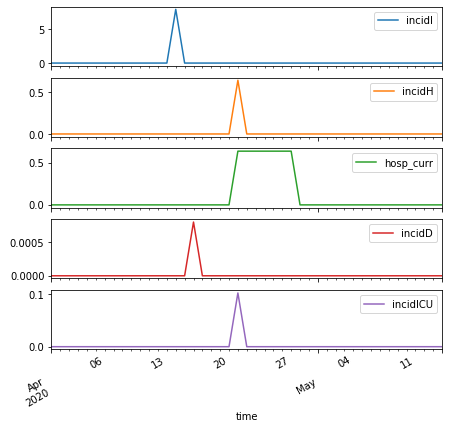

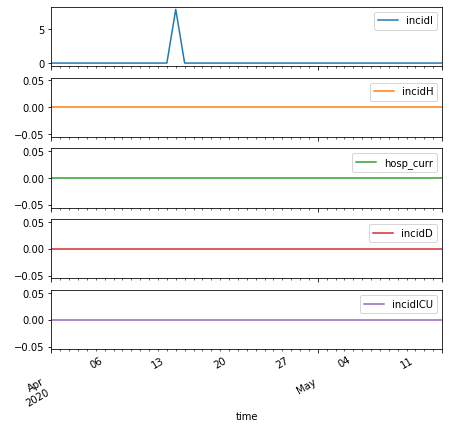

In [36]:
hosp_read = pq.read_table('model_output/hosp/000000001.12.hosp.parquet').to_pandas()
hosp_read.set_index('time', drop = True, inplace=True)
hosp_read = hosp_read[hosp_read['geoid'] == '15003']
hosp_read.plot(subplots=True, figsize = (7,7));
hosp_wrote = pq.read_table('model_output/hosp/000000001.13.hosp.parquet').to_pandas()
hosp_wrote.set_index('time', drop = True, inplace=True)
hosp_wrote = hosp_wrote[hosp_wrote['geoid'] == '15003']
hosp_wrote.plot(subplots=True, figsize = (7,7));

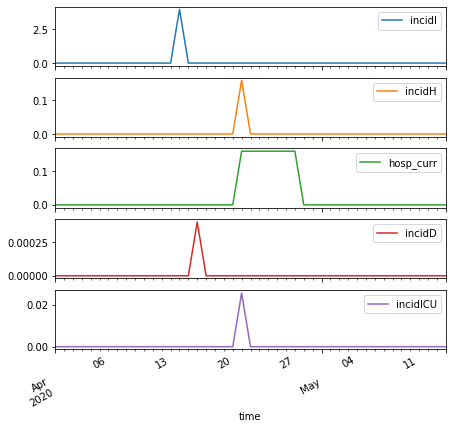

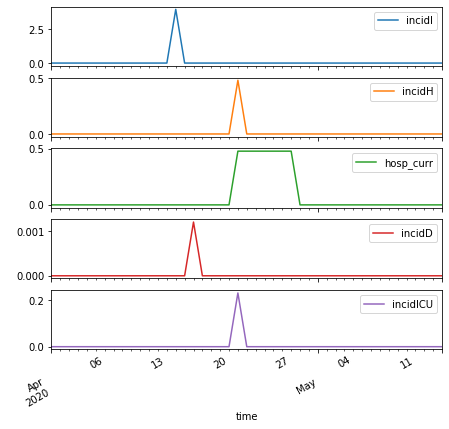

In [38]:
hosp_read = pq.read_table('model_output/hosp/000000001.12.hosp.parquet').to_pandas()
hosp_read.set_index('time', drop = True, inplace=True)
hosp_read = hosp_read[hosp_read['geoid'] == '15009']
hosp_read.plot(subplots=True, figsize = (7,7));
hosp_wrote = pq.read_table('model_output/hosp/000000001.13.hosp.parquet').to_pandas()
hosp_wrote.set_index('time', drop = True, inplace=True)
hosp_wrote = hosp_wrote[hosp_wrote['geoid'] == '15009']
hosp_wrote.plot(subplots=True, figsize = (7,7));